In [1]:
import sys
import os
import numpy as np
sys.path.append('..')
from src import NeuralNet
from src import train as fit
from src import make_directory 
from models import load_model
from data import load_data
from six.moves import cPickle

from subprocess import call

import h5py
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
%matplotlib inline
from scipy.misc import imresize

from lasagne import layers, nonlinearities, updates, objectives, init 
from lasagne.layers import Conv2DLayer, TransposedConv2DLayer, DenseLayer, InputLayer, ExpressionLayer, BiasLayer
from lasagne import regularization

from lasagne.layers import get_output, get_output_shape, get_all_params
import theano.tensor as T
import theano
np.random.seed(247) # for reproducibility

Using gpu device 0: GeForce GTX 980 (CNMeM is disabled, cuDNN 4007)


In [2]:
filename = 'Localized_N=100000_S=200_M=300_G=30_data.pickle'
datapath = '/home/peter/Data/SequenceMotif'
filepath = os.path.join(datapath, filename)

# load training set
print "loading data from: " + filepath
f = open(filepath, 'rb')
print "loading train data"
train = cPickle.load(f)
print "loading cross-validation data"
cross_validation = cPickle.load(f)
print "loading test data"
test = cPickle.load(f)
f.close()

X_train = train[0].transpose((0,1,2)).astype(np.float32)
y_train = train[1].astype(np.int32)
X_val = cross_validation[0].transpose((0,1,2)).astype(np.float32)
y_val = cross_validation[1].astype(np.int32)
X_test = test[0].transpose((0,1,2)).astype(np.float32)
y_test = test[1].astype(np.int32)

X_train = np.expand_dims(X_train, axis=3)
X_val = np.expand_dims(X_val, axis=3)
X_test = np.expand_dims(X_test, axis=3)

train = (X_train, y_train, train[2])
valid = (X_val, y_val, cross_validation[2])
test = (X_test, y_test, test[2])

shape = (None, train[0].shape[1], train[0].shape[2], train[0].shape[3])
num_labels = train[1].shape[1]

loading data from: /home/peter/Data/SequenceMotif/Localized_N=100000_S=200_M=300_G=30_data.pickle
loading train data
loading cross-validation data
loading test data


In [3]:
model_name = "test_motif_model"
nnmodel = NeuralNet(model_name, shape, num_labels)
nnmodel = fit.train_minibatch(nnmodel, train, valid, batch_size=128, num_epochs=500, 
                        patience=3, verbose=1, filepath=filepath)


Epoch 1 out of 500 
[==============================] 100.0% -- time=0s -- loss=0.04340 -- accuracy=98.86%  
  valid loss:		0.00562
  valid accuracy:	0.99828+/-0.00243
  valid auc-roc:	0.99938+/-0.00180
  valid auc-pr:		0.99090+/-0.02548
saving model parameters to: /home/peter/Data/SequenceMotif/Localized_N=100000_S=200_M=300_G=30_data.pickle_epoch_0.pickle
Epoch 2 out of 500 
[==============================] 100.0% -- time=0s -- loss=0.00552 -- accuracy=99.82%  
  valid loss:		0.00332
  valid accuracy:	0.99895+/-0.00151
  valid auc-roc:	0.99974+/-0.00082
  valid auc-pr:		0.99578+/-0.01276
saving model parameters to: /home/peter/Data/SequenceMotif/Localized_N=100000_S=200_M=300_G=30_data.pickle_epoch_1.pickle
Epoch 3 out of 500 
[==============================] 100.0% -- time=0s -- loss=0.00324 -- accuracy=99.89%  
  valid loss:		0.00277
  valid accuracy:	0.99906+/-0.00141
  valid auc-roc:	0.99987+/-0.00038
  valid auc-pr:		0.99708+/-0.00846
saving model parameters to: /home/peter/Data/

In [4]:
network = nnmodel.network
network

{'conv1': <lasagne.layers.conv.Conv2DLayer at 0x7fc27a8c26d0>,
 'conv1_active': <lasagne.layers.special.NonlinearityLayer at 0x7fc2744d1690>,
 'conv1_norm': <lasagne.layers.normalization.BatchNormLayer at 0x7fc27a8c2690>,
 'conv1_pool': <lasagne.layers.pool.MaxPool2DLayer at 0x7fc2744d1810>,
 'conv2': <lasagne.layers.conv.Conv2DLayer at 0x7fc2744d1890>,
 'conv2_active': <lasagne.layers.special.NonlinearityLayer at 0x7fc2744d1f50>,
 'conv2_dropout': <lasagne.layers.noise.DropoutLayer at 0x7fc2744db150>,
 'conv2_norm': <lasagne.layers.normalization.BatchNormLayer at 0x7fc2744d1850>,
 'conv2_pool': <lasagne.layers.pool.MaxPool2DLayer at 0x7fc2744db110>,
 'conv3': <lasagne.layers.conv.Conv2DLayer at 0x7fc2744db210>,
 'conv3_active': <lasagne.layers.special.NonlinearityLayer at 0x7fc2744db1d0>,
 'conv3_dropout': <lasagne.layers.noise.DropoutLayer at 0x7fc2744db250>,
 'conv4': <lasagne.layers.conv.Conv2DLayer at 0x7fc2744db410>,
 'conv4_active': <lasagne.layers.special.NonlinearityLayer at 0

In [5]:
import pandas as pd
def seq_logo(pwm, height=100, nt_width=20, norm=0, rna=0, filepath='.'):
    """generate a sequence logo from a pwm"""
    
    def load_alphabet(filepath, rna):
        """load images of nucleotide alphabet """
        df = pd.read_table(os.path.join(filepath, 'A.txt'), header=None);
        A_img = df.as_matrix()
        A_img = np.reshape(A_img, [72, 65, 3], order="F").astype(np.uint8)

        df = pd.read_table(os.path.join(filepath, 'C.txt'), header=None);
        C_img = df.as_matrix()
        C_img = np.reshape(C_img, [76, 64, 3], order="F").astype(np.uint8)

        df = pd.read_table(os.path.join(filepath, 'G.txt'), header=None);
        G_img = df.as_matrix()
        G_img = np.reshape(G_img, [76, 67, 3], order="F").astype(np.uint8)

        if rna == 1:
            df = pd.read_table(os.path.join(filepath, 'U.txt'), header=None);
            T_img = df.as_matrix()
            T_img = np.reshape(T_img, [74, 57, 3], order="F").astype(np.uint8)
        else:
            df = pd.read_table(os.path.join(filepath, 'T.txt'), header=None);
            T_img = df.as_matrix()
            T_img = np.reshape(T_img, [72, 59, 3], order="F").astype(np.uint8)

        return A_img, C_img, G_img, T_img


    def get_nt_height(pwm, height, norm):
        """get the heights of each nucleotide"""

        def entropy(p):
            """calculate entropy of each nucleotide"""
            s = 0
            for i in range(4):
                if p[i] > 0:
                    s -= p[i]*np.log2(p[i])
            return s

        num_nt, num_seq = pwm.shape
        heights = np.zeros((num_nt,num_seq));
        for i in range(num_seq):
            if norm == 1:
                total_height = height
            else:
                total_height = (np.log2(4) - entropy(pwm[:, i]))*height;
            heights[:,i] = np.floor(pwm[:,i]*total_height);
        return heights.astype(int)

    
    # get the alphabet images of each nucleotide
    A_img, C_img, G_img, T_img = load_alphabet(filepath='.', rna=1)
    
    
    # get the heights of each nucleotide
    heights = get_nt_height(pwm, height, norm)
    
    # resize nucleotide images for each base of sequence and stack
    num_nt, num_seq = pwm.shape
    width = np.ceil(nt_width*num_seq).astype(int)
    
    total_height = np.sum(heights,axis=0)
    max_height = np.max(total_height)
    logo = np.ones((height*2, width, 3)).astype(int)*255;
    for i in range(num_seq):
        remaining_height = total_height[i];
        offset = max_height-remaining_height
        nt_height = np.sort(heights[:,i]);
        index = np.argsort(heights[:,i])

        for j in range(num_nt):
            if nt_height[j] > 0:
                # resized dimensions of image
                resize = (nt_height[j], nt_width)
                if index[j] == 0:
                    nt_img = imresize(A_img, resize)
                elif index[j] == 1:
                    nt_img = imresize(C_img, resize)
                elif index[j] == 2:
                    nt_img = imresize(G_img, resize)
                elif index[j] == 3:
                    nt_img = imresize(T_img, resize)

                # determine location of image
                height_range = range(remaining_height-nt_height[j], remaining_height)
                width_range = range(i*nt_width, i*nt_width+nt_width)

                # 'annoying' way to broadcast resized nucleotide image
                if height_range:
                    for k in range(3):
                        for m in range(len(width_range)):
                            logo[height_range+offset, width_range[m],k] = nt_img[:,m,k];

                remaining_height -= nt_height[j]

    return logo.astype(np.uint8)


In [6]:
def maxunpool(X, pool, active):
    pool_size = active.shape[2]/pool.shape[2]
    fmap1 = []
    for k in range(active.shape[0]):
        x = np.squeeze(active[k],axis=(2,))
        mymap = np.squeeze(pool[k],axis=(2,))

        max_index = []
        for i in range(x.shape[1]/pool_size):
            index = range(i*pool_size,(i+1)*pool_size)
            max_index.append(np.argmax(x[:,index],axis=1))
        max_index = np.array(max_index)
        max_index

        dim,seq_length = mymap.shape
        fmap_unpool = np.zeros((dim,seq_length*pool_size))
        for i in range(x.shape[1]/pool_size):
            index = range(i*pool_size,(i+1)*pool_size)
            for j in range(dim):
                fmap_unpool[j,index[max_index[i][j]]] = mymap[j,i]
        fmap1.append(fmap_unpool)

    fmap1 = np.array(fmap1)
    fmap1 = np.expand_dims(fmap1, 3)
    return fmap1 

def deconvolution(fmap, layer):
    # psuedo-inverse filters
    W4 = layer.W.get_value()

    # deconvolution layer 2
    input_var4 = T.tensor4('conv4')
    shape4 = list(fmap.shape)
    shape4[0] = None
    input4 = InputLayer(shape=tuple(shape4), input_var=input_var4)
    #unpool4 = ExpressionLayer(input4, lambda X: T.log(T.exp(X)-1 + 1e-7), output_shape='auto')
    #unpool4 = BiasLayer(unpool4, b=-network['conv2_bias'].b)
    if layer.pad == 'valid':
        pad = 'full'
    else:
        pad = 'same'
    deconv4 = Conv2DLayer(input4, num_filters=layer.input_shape[1],
                                          filter_size=layer.filter_size,
                                          W=layer.W.dimshuffle([1,0,2,3]), #W2_inv, #
                                          b=None, 
                                          pad= 'full' if layer.pad==(0,0) else 'same',
                                          nonlinearity=None, flip_filters=False)
    predict = theano.function([input_var4], get_output(deconv4, deterministic=True), allow_input_downcast=True)

    intermediate = predict(fmap.astype(np.float32))
    return np.array(intermediate)

def get_feature_map_all(layer, input_var, X):
    get_map = theano.function([input_var], get_output(layer), allow_input_downcast=True)
    return get_map(X)

 
def activation_filter(layer, percentile, window=0, norm=0):
    pool = np.squeeze(layer[0], axis=2)
    if norm:
        pool = np.abs(pool)
        
    pool_flat = pool.reshape([-1,])
    num_data = len(pool_flat)
    cutoff = np.round(num_data*percentile).astype(int)
    threshold = np.sort(pool_flat)[-cutoff]

    if norm:
        sum_spikes = np.max(np.abs(pool),axis=0)
    else:
        sum_spikes = np.max(pool,axis=0)
        
    index = np.where(sum_spikes > threshold)[0]
    fmap = np.zeros(pool.shape)
    for i in index:
        MIN = np.maximum(0, i-window)
        MAX = np.minimum(pool.shape[1],i+window+1)
        fmap[:,MIN:MAX] = pool[:,MIN:MAX]
    fmap = np.expand_dims(fmap,0)
    fmap = np.expand_dims(fmap,3)
    return fmap, threshold

def max_filter(layer, percentile, window=0, norm=0):
    pool = np.squeeze(layer[0], axis=2)
    if norm:
        pool = np.abs(pool)
    max_pool = np.max(pool, axis=0)
    num_data = len(max_pool)
    cutoff = np.round(num_data*percentile).astype(int)
    threshold = np.sort(max_pool)[-cutoff]
    
    index = np.where(max_pool > threshold)[0]
    fmap = np.zeros(pool.shape)
    for i in index:
        MIN = np.maximum(0, i-window)
        MAX = np.minimum(pool.shape[1],i+window+1)
        fmap[:,MIN:MAX] = pool[:,MIN:MAX]
    fmap = np.expand_dims(fmap,0)
    fmap = np.expand_dims(fmap,3)
    return fmap, threshold

def same_unpool_fmap(layer, seq_length):
    activation = np.squeeze(layer[0], axis=2)
    num_channels, num_map = activation.shape

    num_unpool = np.floor(seq_length/num_map).astype(int)
    amap = np.zeros((num_channels, seq_length))
    for i in range(num_map):
        amap[:,range(i*num_unpool,(i+1)*num_unpool)] = np.outer(activation[:,i], np.ones(num_unpool))
    return amap

# importance analysis

In [8]:
map_index = 54#14, 16, 22, 17, 172, 

savename = 'Unlocalized_medium_'+str(map_index)+'_'
savedir = '/home/peter/Documents/'+savename

X = test[0][map_index]
X = np.expand_dims(X,0)
y = test[1][map_index]
model = test[2][map_index]
print X.shape

seq_length = X.shape[2]

(1, 4, 200, 1)


In [9]:
# get prediction
get_prediction = theano.function([nnmodel.input_var], layers.get_output(network['output'], deterministic=True), allow_input_downcast=True)
prediction = get_prediction(X)
print 'ground truth = ' + str(np.argmax(y))
print 'prediction = ' + str(np.argmax(prediction))

class_index = np.argmax(y)

ground truth = 21
prediction = 21


/home/peter/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


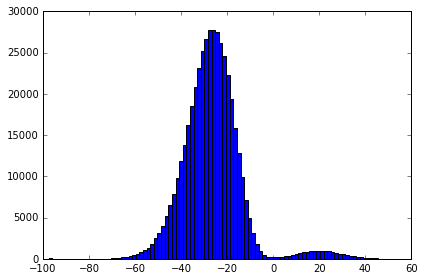

In [10]:
fmap = get_feature_map_all(network['conv4'], nnmodel.input_var, test[0])
fmap = np.squeeze(fmap)
plt.hist(fmap.reshape([-1,]),bins=100);

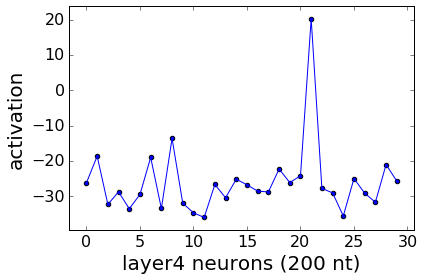

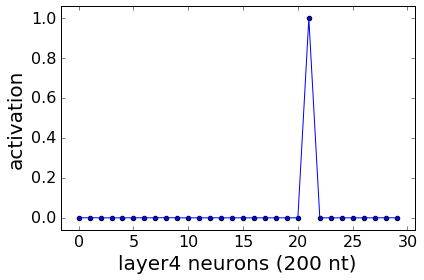

In [11]:
# get dense layer
get_conv4 = theano.function([nnmodel.input_var], layers.get_output(network['conv4'], deterministic=True), allow_input_downcast=True)
conv4 = get_conv4(X)
conv4_flat = np.squeeze(conv4[0],axis=2)


fig = plt.figure()
plt.plot(conv4_flat);
plt.scatter(range(30),conv4_flat);
plt.axis('tight')
ax = plt.gca()
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.xlabel('layer4 neurons (200 nt)', fontsize=20)
plt.ylabel('activation', fontsize=20)
#outfile = savedir+ 'conv4_'+ str(class_index)  + '.pdf'
#fig.savefig(outfile, format='pdf', dpi=1000)  
#call(['pdfcrop', outfile, outfile])

        
MAX = np.max(conv4)
conv4 = conv4/MAX*4
conv4 = np.exp(conv4)
conv4 = conv4/np.max(conv4)


conv4_flat = np.squeeze(conv4[0],axis=2)


fig = plt.figure()
plt.plot(conv4_flat);
plt.scatter(range(30),conv4_flat);
plt.axis('tight')
ax = plt.gca()
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.xlabel('layer4 neurons (200 nt)', fontsize=20)
plt.ylabel('activation', fontsize=20)
#outfile = savedir+ 'conv4_'+ str(class_index)  + '.pdf'
#fig.savefig(outfile, format='pdf', dpi=1000)  
#call(['pdfcrop', outfile, outfile])




In [12]:

#conv4 = np.ones(30)*0
#conv4[class_index]=5
#conv4 = np.expand_dims(conv4,0)
#conv4 = np.expand_dims(conv4,2)
#conv4 = np.expand_dims(conv4,3)


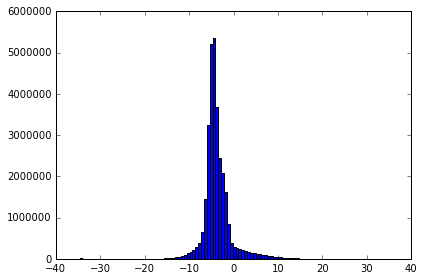

In [13]:
fmap = get_feature_map_all(network['conv3'], nnmodel.input_var, test[0])
fmap = np.squeeze(fmap)
plt.hist(fmap.reshape([-1,]),bins=100);

In [54]:
conv4 = get_conv4(test[0])
conv3 = deconvolution(conv4, network['conv4'])
conv3 = np.squeeze(conv3)

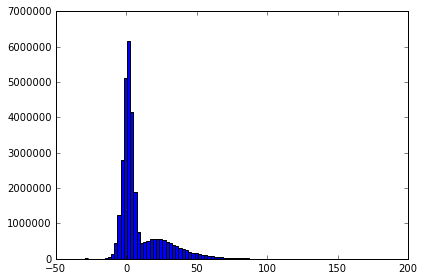

In [55]:
plt.hist(conv3.reshape([-1,]),bins=100);

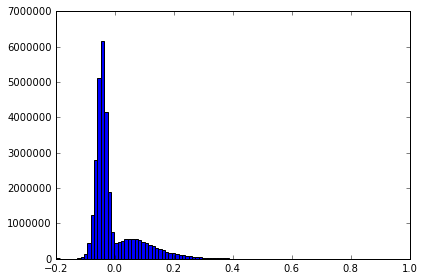

In [56]:
MAX = np.max(conv3)
conv3 = conv3/MAX
conv3 -= .05
plt.hist(conv3.reshape([-1,]),bins=100);


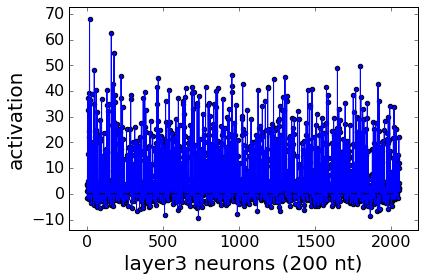

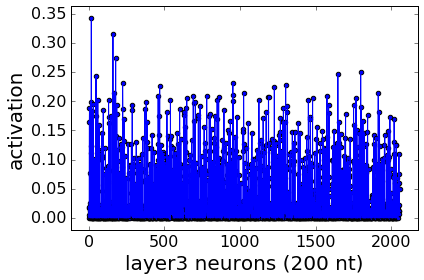

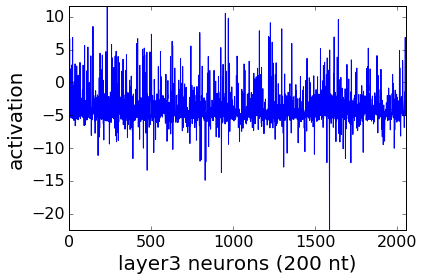

In [58]:
conv3 = deconvolution(conv4, network['conv4'])
conv3_flat = np.squeeze(conv3[0],axis=2)

fig = plt.figure()
plt.plot(conv3_flat);
plt.scatter(range(len(conv3_flat)),conv3_flat);
plt.axis('tight')
ax = plt.gca()
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.xlabel('layer3 neurons (200 nt)', fontsize=20)
plt.ylabel('activation', fontsize=20)




threshold = 0#np.max(conv3)*.8
#conv3[conv3<threshold] = .0
MAX = np.max(conv3)
conv3 = conv3/MAX
conv3[conv3<0] = 0
#conv3 = conv3*MAX
#


plt.plot(range(len(conv3_flat)), np.ones(len(conv3_flat))*threshold, color='k', linestyle='--')
#outfile = savedir+ 'deconv3_'+ str(class_index)  + '.pdf'
#fig.savefig(outfile, format='pdf', dpi=1000)  
#call(['pdfcrop', outfile, outfile])

conv3_flat = np.squeeze(conv3[0],axis=2)
fig = plt.figure()
plt.plot(conv3_flat);
plt.scatter(range(len(conv3_flat)),conv3_flat);
plt.axis('tight')
ax = plt.gca()
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.xlabel('layer3 neurons (200 nt)', fontsize=20)
plt.ylabel('activation', fontsize=20)
#outfile = savedir+ 'deconv3_filter_'+ str(class_index)  + '.pdf'
#fig.savefig(outfile, format='pdf', dpi=1000)  
#call(['pdfcrop', outfile, outfile])



conv3_active = get_feature_map_all(network['conv3'], nnmodel.input_var, X)
fig = plt.figure()
plt.plot(np.squeeze(conv3_active[0]));
plt.axis('tight')
ax = plt.gca()
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.xlabel('layer3 neurons (200 nt)', fontsize=20)
plt.ylabel('activation', fontsize=20)
#outfile = savedir+ 'conv3_'+ str(class_index)  + '.pdf'
#fig.savefig(outfile, format='pdf', dpi=1000)  
#call(['pdfcrop', outfile, outfile])




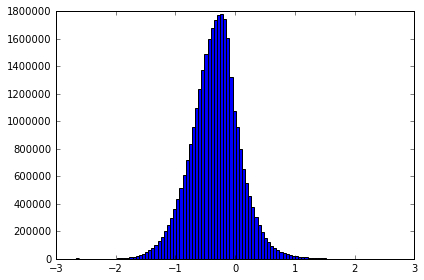

In [59]:
conv2_pool = deconvolution(conv3, network['conv3'])
conv2_pool = np.squeeze(conv2_pool)
plt.hist(conv2_pool.reshape([-1,]),bins=100);

In [84]:
conv2_pool.shape

(15000, 512, 4)

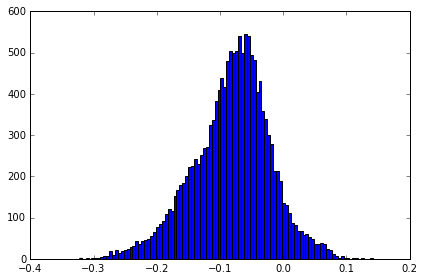

In [94]:
conv2_pool = deconvolution(conv3, network['conv3'])
conv2_pool = np.squeeze(conv2_pool)
plt.hist(conv2_pool.reshape([15000,-1])[:,50],bins=100);

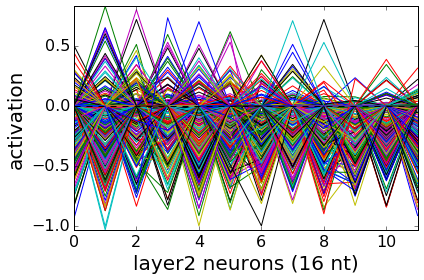

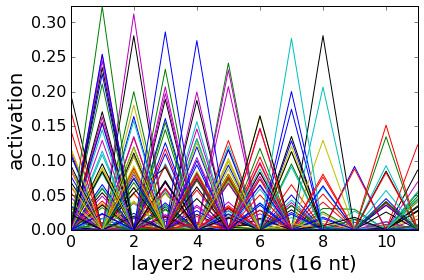

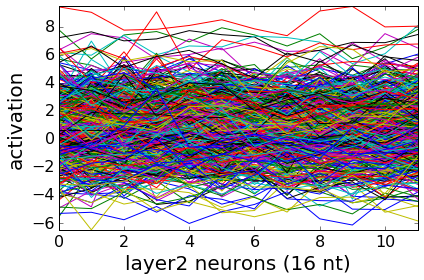

In [72]:
# get dense layer
#get_conv2 = theano.function([nnmodel.input_var], layers.get_output(network['conv2'], deterministic=True), allow_input_downcast=True)
#conv2 = get_conv2(X)

conv2_pool = deconvolution(conv3, network['conv3'])
conv2_active = get_feature_map_all(network['conv2'], nnmodel.input_var, test[0])
conv2 = maxunpool(test[0], conv2_pool, conv2_active)

conv2_flat = np.squeeze(conv2[0],axis=2)


fig = plt.figure()
plt.plot(conv2_flat.T);
plt.axis('tight')
ax = plt.gca()
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.xlabel('layer2 neurons (16 nt)', fontsize=20)
plt.ylabel('activation', fontsize=20)


threshold = 0#np.max(conv2)*.8
#conv2[conv2<threshold] = .0
MAX = np.max(conv2)
conv2 = conv2/MAX
#conv2 = np.exp(conv2)
#conv2 =conv2/np.max(conv2)
#conv2 -= .05
conv2[conv2<0.0] = 0



plt.plot(range(len(conv2_flat)), np.ones(len(conv2_flat))*threshold, color='k', linestyle='--')
#outfile = savedir+ 'deconv2_'+ str(class_index)  + '.pdf'
#fig.savefig(outfile, format='pdf', dpi=1000)  
#call(['pdfcrop', outfile, outfile])

conv2_flat = np.squeeze(conv2[0],axis=2)
fig = plt.figure()
plt.plot(conv2_flat.T);
plt.axis('tight')
ax = plt.gca()
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.xlabel('layer2 neurons (16 nt)', fontsize=20)
plt.ylabel('activation', fontsize=20)
#outfile = savedir+ 'deconv2_filter_'+ str(class_index)  + '.pdf'
#fig.savefig(outfile, format='pdf', dpi=1000)  
#call(['pdfcrop', outfile, outfile])




fig = plt.figure()
plt.plot(np.squeeze(conv2_active[0],axis=2).T);
plt.axis('tight')
ax = plt.gca()
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.xlabel('layer2 neurons (16 nt)', fontsize=20)
plt.ylabel('activation', fontsize=20)
#outfile = savedir+ 'conv2_'+ str(class_index)  + '.pdf'
#fig.savefig(outfile, format='pdf', dpi=1000)  
#call(['pdfcrop', outfile, outfile])




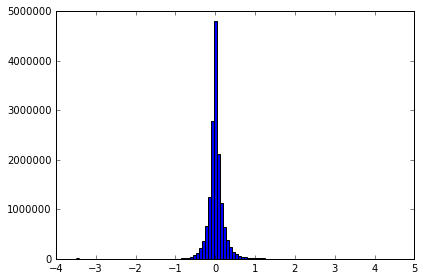

In [73]:
conv1_pool = deconvolution(conv2, network['conv2'])
conv1_pool = np.squeeze(conv1_pool)
plt.hist(conv1_pool.reshape([-1,]),bins=100);

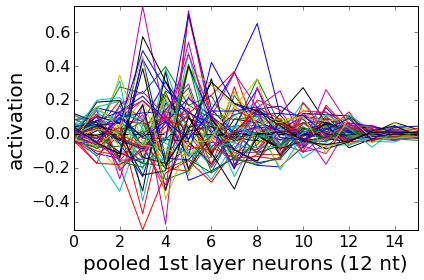

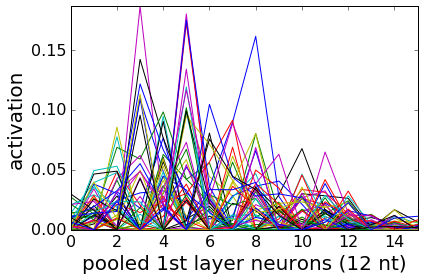

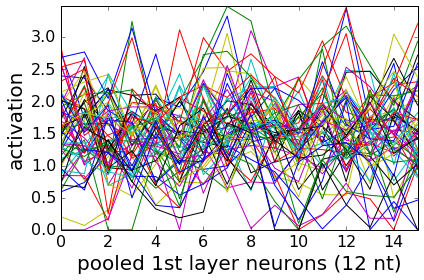

In [74]:

conv1_pool = deconvolution(conv2, network['conv2'])
pool = np.squeeze(conv1_pool[0])

fig=plt.figure()
plt.plot(pool.T);
plt.axis('tight')
ax = plt.gca()
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.xlabel('pooled 1st layer neurons (12 nt)', fontsize=20)
plt.ylabel('activation', fontsize=20)



threshold = 0#np.max(conv1_pool)*.5
#conv1_pool[conv1_pool<threshold] = .0
MAX = np.max(conv1_pool)
conv1_pool = conv1_pool/MAX
#conv1_pool = np.exp(conv1_pool)
#conv1_pool = conv1_pool/np.max(conv1_pool)
#conv1_pool -= .05
conv1_pool[conv1_pool<0] = 0


plt.plot(range(pool.shape[1]), np.ones(pool.shape[1])*threshold, color='k', linestyle='--')
#outfile = savedir+ 'deconv1_'+ str(class_index)  + '.pdf'
#fig.savefig(outfile, format='pdf', dpi=1000)  
#call(['pdfcrop', outfile, outfile])

fig = plt.figure()
plt.plot(np.squeeze(conv1_pool[0]).T);
plt.axis('tight')
ax = plt.gca()
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.xlabel('pooled 1st layer neurons (12 nt)', fontsize=20)
plt.ylabel('activation', fontsize=20)
#outfile = savedir+ 'deconv1_filter_'+ str(class_index)  + '.pdf'
#fig.savefig(outfile, format='pdf', dpi=1000)  
#call(['pdfcrop', outfile, outfile])



pool = get_feature_map_all(network['conv1_pool'], nnmodel.input_var, X)
fig = plt.figure()
plt.plot(np.squeeze(pool[0]).T);
plt.axis('tight')
ax = plt.gca()
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.xlabel('pooled 1st layer neurons (12 nt)', fontsize=20)
plt.ylabel('activation', fontsize=20)
#outfile = savedir+ 'conv1pool_'+ str(class_index)  + '.pdf'
#fig.savefig(outfile, format='pdf', dpi=1000)  
#call(['pdfcrop', outfile, outfile])


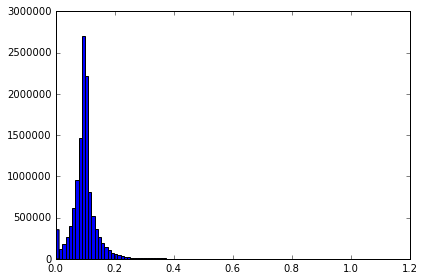

In [81]:
conv1_pool = deconvolution(conv2, network['conv2'])
MAX = np.max(conv1_pool)
conv1_pool = conv1_pool/MAX
conv1_pool[conv1_pool<0.0] = 0

conv1_active = get_feature_map_all(network['conv1'], nnmodel.input_var, test[0])
conv1 = maxunpool(test[0], conv1_pool, conv1_active)
reconstruction = deconvolution(conv1, network['conv1'])


MAX = np.max(reconstruction)
reconstruction = reconstruction/MAX
reconstruction += 0.1
reconstruction[reconstruction<0] = 0 
plt.hist(reconstruction.reshape([-1,]),bins=100);

(-0.5, 3999.5, 199.5, -0.5)

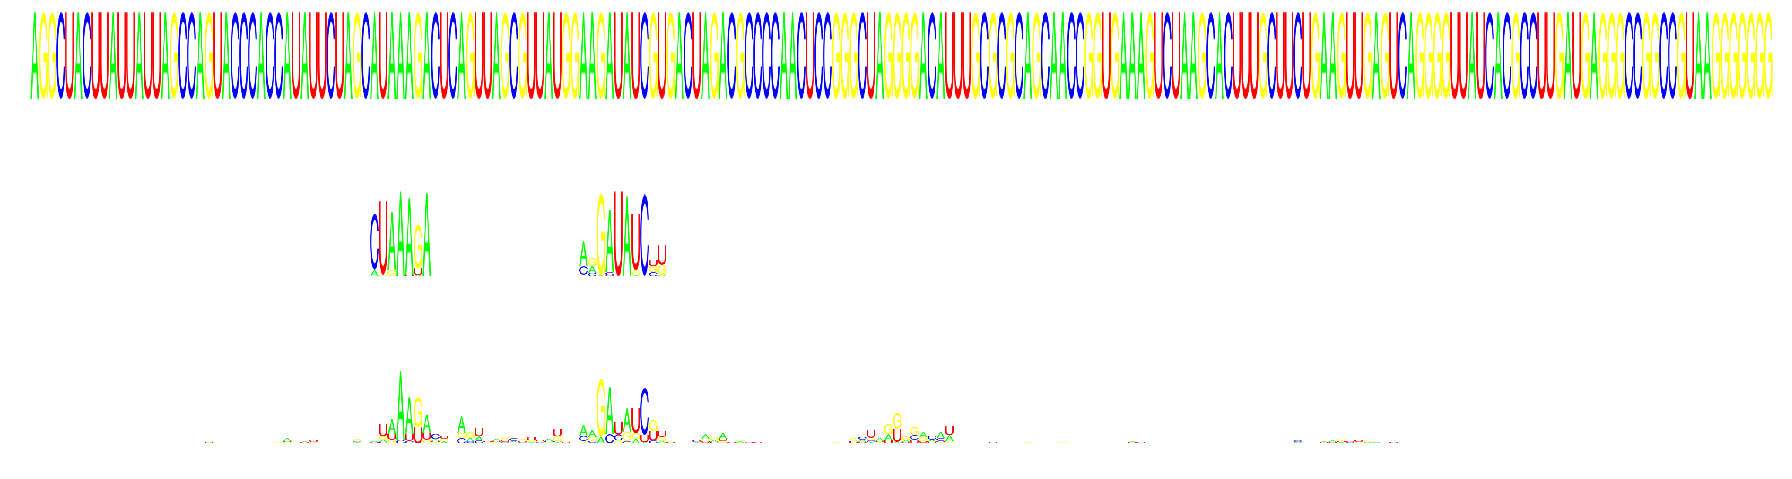

In [82]:
index = 15

height=100
bp_width=20
size = (25.,10.0)

logo = seq_logo(np.squeeze(test[0][index]), height, bp_width, norm=0, rna=1, filepath='.')
fig = plt.figure(figsize=size);

plt.subplot(3,1,1)
plt.imshow(logo, interpolation='none');
plt.axis('off');


plt.subplot(3,1,2)
logo = seq_logo(test[2][index], height, bp_width, norm=0, rna=1, filepath='.')
plt.imshow(logo, interpolation='none');
plt.axis('off');

pwm = np.squeeze(reconstruction[index])
norm = np.outer(np.ones(4), np.sum(pwm, axis=0))
pwm = pwm/norm

plt.subplot(3,1,3)
logo = seq_logo(pwm, height, bp_width, norm=0, rna=1, filepath='.')
plt.imshow(logo, interpolation='none');
plt.axis('off');
#outfile = savedir+ 'reconstructed_'+ str(class_index)  + '.pdf'
#fig.savefig(outfile, format='pdf', dpi=1000)  


In [ ]:
conv1_active = get_feature_map_all(network['conv1'], nnmodel.input_var, test[0])
conv1 = maxunpool(X, conv1_pool, conv1_active)
reconstruction = deconvolution(conv1, network['conv1'])


fig = plt.figure()
plt.plot(np.squeeze(conv1_active[0]).T)
plt.axis('tight')
ax = plt.gca()
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.xlabel('sequence (nt)', fontsize=20)
plt.ylabel('activation', fontsize=20)
#outfile = savedir+ 'conv1_'+ str(class_index)  + '.pdf'
#fig.savefig(outfile, format='pdf', dpi=1000) 


fig = plt.figure()
plt.plot(np.squeeze(reconstruction[0]).T)
plt.axis('tight')
ax = plt.gca()
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.xlabel('sequence (nt)', fontsize=20)
plt.ylabel('activation', fontsize=20)
#outfile = savedir+ 'deconv0_'+ str(class_index)  + '.pdf'
#fig.savefig(outfile, format='pdf', dpi=1000) 


pwm = np.squeeze(reconstruction[0])
MAX = np.max(pwm)
pwm = pwm/MAX
#pwm = np.exp(pwm)
pwm += 0.25
pwm[pwm<0] = 0
norm = np.outer(np.ones(4), np.sum(pwm, axis=0))
pwm = pwm/norm

fig = plt.figure()
plt.plot(pwm.T);
plt.axis('tight')
ax = plt.gca()
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.xlabel('sequence (nt)', fontsize=20)
plt.ylabel('normalized activation', fontsize=20)
#outfile = savedir+ 'deconv0_no6malized_'+ str(class_index)  + '.pdf'
#fig.savefig(outfile, format='pdf', dpi=1000)  



In [ ]:
height=100
bp_width=20
size = (25.,10.0)

logo = seq_logo(np.squeeze(X[0]), height, bp_width, norm=0, rna=1, filepath='.')
fig = plt.figure(figsize=size);

plt.subplot(3,1,1)
plt.imshow(logo, interpolation='none');
plt.axis('off');


plt.subplot(3,1,2)
logo = seq_logo(model, height, bp_width, norm=0, rna=1, filepath='.')
plt.imshow(logo, interpolation='none');
plt.axis('off');


plt.subplot(3,1,3)
logo = seq_logo(pwm, height, bp_width, norm=0, rna=1, filepath='.')
plt.imshow(logo, interpolation='none');
plt.axis('off');
outfile = savedir+ 'reconstructed_'+ str(class_index)  + '.pdf'
fig.savefig(outfile, format='pdf', dpi=1000)  


In [ ]:
pwm = np.squeeze(reconstruction[0])

plt.plot(pwm.T)

# T-sne

In [ ]:
def ImportanceDeconvolution(X, network):

    seq_length = X.shape[2]

    # get dense layer
    get_conv4 = theano.function([nnmodel.input_var], layers.get_output(network['conv4'], deterministic=True), allow_input_downcast=True)
    conv4 = get_conv4(X)
    MAX = np.max(conv4)
    conv4 = conv4/MAX*4
    conv4 = np.exp(conv4)
    conv4 = conv4/np.max(conv4)

    conv3 = deconvolution(conv4, network['conv4'])
    conv3_flat = np.squeeze(conv3[0],axis=2)
    MAX = np.max(conv3)
    conv3 = conv3/MAX*4
    conv3 = np.exp(conv3)
    conv3 =conv3/np.max(conv3)
    conv3[conv3<0.05] = 0

    conv2_pool = deconvolution(conv3, network['conv3'])
    conv2_active = get_feature_map_all(network['conv2'], nnmodel.input_var, X)
    conv2 = maxunpool(X, conv2_pool, conv2_active)
    MAX = np.max(conv2)
    conv2 = conv2/MAX*4
    conv2 = np.exp(conv2)
    conv2 =conv2/np.max(conv2)
    conv2[conv2<0.05] = 0

    conv1_pool = deconvolution(conv2, network['conv2'])
    pool = np.squeeze(conv1_pool[0])
    MAX = np.max(conv1_pool)
    conv1_pool = conv1_pool/MAX*4
    conv1_pool = np.exp(conv1_pool)
    conv1_pool = conv1_pool/np.max(conv1_pool)
    conv1_pool[conv1_pool<0.1] = 0
    
    conv1_active = get_feature_map_all(network['conv1'], nnmodel.input_var, X)
    conv1 = maxunpool(X, conv1_pool, conv1_active)
    reconstruction = deconvolution(conv1, network['conv1'])

    pwm = np.squeeze(reconstruction[0])
    MAX = np.max(pwm)
    pwm = pwm/MAX*6
    pwm = np.exp(pwm)
    pwm = pwm/np.max(pwm)
    norm = np.outer(np.ones(4), np.sum(pwm, axis=0))
    pwm = pwm/norm

    return pwm



In [ ]:
pwm = []
for i in range(test[0].shape[0]):
    X = test[0][map_index]
    X = np.expand_dims(X,0)
    pwm.append(ImportanceDeconvolution(X, network))

In [ ]:
pwm = np.array(pwm)
pwm_input = pwm.reshape([pwm.shape[0],-1])

In [ ]:
conv3_active = get_feature_map_all(network['conv3_active'], nnmodel.input_var, test[0])

In [ ]:
conv3_active.reshape([conv3_active.shape[0],-1]).shape

In [ ]:
from tsne import bh_sne
vis_data = bh_sne(conv3_active.reshape([conv3_active.shape[0],-1]).astype(np.float64))

In [ ]:

def tSNE_plot(vis_data, labels):
    """scatter plot of tSNE 2D projections, with a color corresponding to labels"""
    num_labels = max(labels)+1
    vis_x = vis_data[:,0]
    vis_y = vis_data[:,1]
    plt.figure(figsize = (10,10))
    fig = plt.gcf()
    fig.set_size_inches(50, 50, forward=True)
    plt.scatter(vis_x, vis_y, c=labels, cmap=plt.cm.get_cmap("jet", num_labels), s=300, edgecolor=None)
    plt.axis('off')
    return plt


y_train = np.argmax(test[1],axis=1)
plt = tSNE_plot(vis_data[:4000,:], y_train[:4000])   